### Dinkey Treatment Placement

The second chunk of the JFSP proposal as it related to Dinkey Creek Watershed indicates that we will take our No Action simulations from the extreme fire weather scenario and use the mean fire severity to assign treatment placements. Further, we will not be doing any Thin Only simulations, it just doesn't make sense, as the first manuscript will indicate the potential for increased fire severity with thinning in the absence of RxFire. 

Proposed approach here, classify the mean fire severity layer by vegetation type to generate actionable treatment placement opportunities. The first step will be to take our mean fire severity raster and operate over it with a classifyer. Teachable moment, figure I'd do it all in Python.

In [8]:
# Load required libraries and establish data directories

# ------- Notebook config
%matplotlib inline
import matplotlib.pyplot as plt

# ------- Load dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import gdal
import os

# ------- Working directory
dataDir = 'Z:/Dan K/DinkeyCreek/LANDIS_RUNS/ProductionV2/'

#### Import some functions we developed earlier
Specifically, we're looking to work with the severity raster data from the previous simulations. We first pull them into a numpy list of gdal arrays (severityStack), then we build a zstack with numpy's dstack so that we can calculate the mean and variance of each pixel across replicates (severityGen).

In [4]:
def severityStack(rasterLoc, runLength):
    rasterlist = []
    timesteps = np.linspace(1,runLength,runLength)
    
    repnames = next(os.walk(rasterLoc))[1]
    num_replicates = len(repnames)

    idx = 0
    for rep in repnames:
        counter = 0
        repnum = rep.split('replicate')[1]
        for time in timesteps:  
            wkDir_data = rasterLoc + '/' 'replicate' + repnum + '/' + 'fire/'
            sevmap = 'severity-' + str(int(time)) + '.img'
            src_ds = gdal.Open( wkDir_data + sevmap ) 
            sevarray = src_ds.ReadAsArray()
            sevarray = sevarray.astype('float')
            rasterlist.append(sevarray)            
    return rasterlist


def severityGen(rasterList):
    rasterStack = np.dstack(rasterList)  
    rasterAdj = rasterStack - 2
    rasterAdj[rasterAdj < 0] = np.nan
    meanSev = np.nanmean(rasterAdj, axis = 2)
    varSev = np.nanvar(rasterAdj, axis = 2)
    return meanSev, varSev

#### Read in the mean severity map for the No Action scenario
Leverage our previous work to create a mean severity raster from the previous Dinkey simulations. Were going to use this raster as the starting point from which to begin to designate treatment placements. For now we'll just display it.

In [68]:
# We only care about one simulation name for now...
simName = 'NoMgmtSevereFireLowP'

sevMapsLowP = []
sevVarMapsLowP = []

sevrasters = severityStack(dataDir + simName, 100)
sevMap, sevVarMap = severityGen(sevrasters)
sevmap = {simName : sevMap}
sevVarmap = {simName : sevVarMap}

sevMapsLowP.append(sevmap)
sevVarMapsLowP.append(sevVarmap)

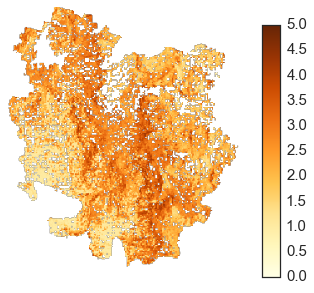

In [69]:
# Plot our hard earned severity raster
f, ax = plt.subplots(1,1, figsize =(5,5))
plt.subplots_adjust(wspace = -.5, hspace = 0.1)

sevMap = ax.imshow(sevMapsLowP[0][simName], cmap = 'YlOrBr', vmin = 0, vmax = 5)

# Remove the axes
sns.despine()
for ax in f.axes:
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

# Add the color bar
cbar_ax = f.add_axes([0.90, 0.15, 0.05, 0.7])
f.colorbar(sevMap, cax=cbar_ax)


sns.set_style('white')
sns.set_context('notebook',font_scale=1.5)

### Discretize the fire severity raster
We want to bin the fire severities in this raster into discrete groups, to make a thematic description of fire severity. I'll create a function to do this, so we can use it down the road -- we want to describe an arbitrary number of bins, and have control over bin size. For now we will keep bin sizes to 1.

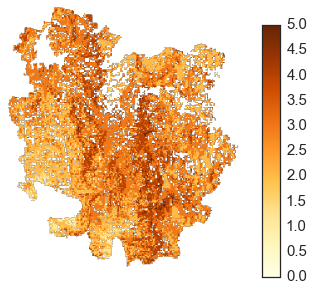

In [83]:
def binRaster(rasterName):
    binnedRaster = np.zeros_like(rasterName)
    idx = 0
    binMin = 0
    binMax = 5
    bins = np.linspace(binMin,binMax,binMax + 1)
    for thisBin in bins:
        if thisBin < binMax:
            binnedRaster[(rasterName > thisBin) & (rasterName <= (thisBin + 1))] = thisBin + 1
    return binnedRaster

binnedSEV = binRaster(sevMapsLowP[0][simName])
binnedSEV[binnedSEV == 0] = np.nan

# Plot our hard earned severity raster
f, ax = plt.subplots(1,1, figsize =(5,5))

sevMap = ax.imshow(binnedSEV, cmap = 'YlOrBr', vmin = 0, vmax = 5)

# Remove the axes
sns.despine()
for ax in f.axes:
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

# Add the color bar
cbar_ax = f.add_axes([0.90, 0.15, 0.05, 0.7])
f.colorbar(sevMap, cax=cbar_ax)


sns.set_style('white')
sns.set_context('notebook',font_scale=1.5)

#### It looks the exact same ... 
what the heck. Well, it makes sense actually, lets look for the difference between the two rasters for peace of mind. We created 5 bins, so really the difference between the continuous raster and the binned raster should always be <= 1.0. 

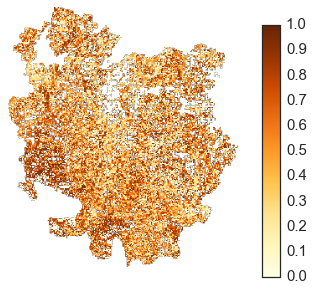

In [79]:
sevDiff = binnedSEV - sevMapsLowP[0][simName]

f, ax = plt.subplots(1,1, figsize =(5,5))
sevMap = ax.imshow(sevDiff, cmap = 'YlOrBr', vmin = 0, vmax = 1)

# Remove the axes
sns.despine()
for ax in f.axes:
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

# Add the color bar
cbar_ax = f.add_axes([0.90, 0.15, 0.05, 0.7])
f.colorbar(sevMap, cax=cbar_ax)


sns.set_style('white')
sns.set_context('notebook',font_scale=1.5)

#### Looks good, we basically removed the decimals from our raster. 
Deos this even make sense to do? My first thought was just discretize the raster, and go from there... maybe a better way to approach it is to look at the distribution of fire severities across the watershed in our continuous raster, and pick from the distribution to create classes. Lets start with a histogram of severities.

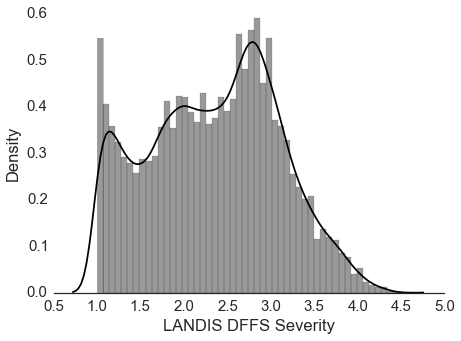

In [132]:
# Create a pandas dataframe out of the numpy array
sevdf = pd.DataFrame(dict(SEV = sevMapsLowP[0][simName].ravel()))

f, ax = plt.subplots(1,1, figsize =(7,5))
sns.distplot(sevdf.SEV.dropna(), color = 'k')
ax.set_xlabel('LANDIS DFFS Severity')
ax.set_ylabel('Density')
sns.despine(left=True)


#### Alright, now we can make some informed decisions here. 
One way to handle where breaks aught to occurr is to use the framework of the DFFS... meaning, we're OK with severity 1-2, want to allow some severity 3 fires, and generally want to manage portions of the landscape where severity 4 and 5 are likely in the future. That would result in 3 bins: 0-2, 2-4, 4-5. 

This makes sense from a management perspective, but if we leverage the data here a bit more and ask what are the number of ha that fall into each of those classes, maybe we can drill down a bit more empirically to address the problem.

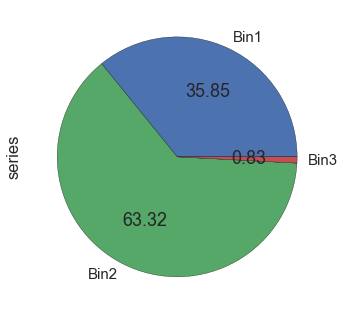

In [140]:
# I smell a pie chart
cherryPie = pd.Series([sevdf[sevdf.SEV <=2].count()[0],
                 sevdf[(sevdf.SEV > 2) & (sevdf.SEV < 4)].count()[0],
                 sevdf[sevdf.SEV >=4].count()[0]],
                 index=['Bin1','Bin2','Bin3'], name='series')

f, ax = plt.subplots(1,1, figsize =(5,5))

ax.set_aspect('equal')
cherryPie.plot.pie(ax = ax, autopct='%.2f')
plt.tight_layout()

#### Thats really gross. I love pie charts.
Also. we can see that Bin 3 is a tiny sliver of the landscape. Maybe this is OK, these are the regions we're going to have to hit the hardest, as their MEAN Severity was 4 or above, and thats across 50 replicates at 100 years a piece. Lets look at the cumulative distribution function (CDF) for our histogram of burn severities and see if we can't develop 3 bins based on the relative abundance of the mean severities across the watershed.

Since the cdf is just the probability density function (PDF) summed up over an ordered data set, we can just use a kernel density estimator to generate our PDF, and calculate the sum of that gaussian over our x-axis to get the CDF. With that function, we should be able to ask the question: 'At what mean fire severity are we going to capture X% of our observations?

In [ ]:
# The kernel operators here take a bit of time, so I'll generate the DF in a separate
# cell, and plot the results below.

from scipy import optimize, stats # Using Scipy here for the kernel operator bits. Not using
                                  # Optimize at all, but if we want to fit gaussians to our data,
                                  # that's how Id go about doing it.  

kernel = stats.gaussian_kde(sevdf.SEV.dropna())

yy = kernel(sevdf.SEV)
xx = sevdf.SEV
sevData = pd.DataFrame(dict(severities = xx, density = yy))

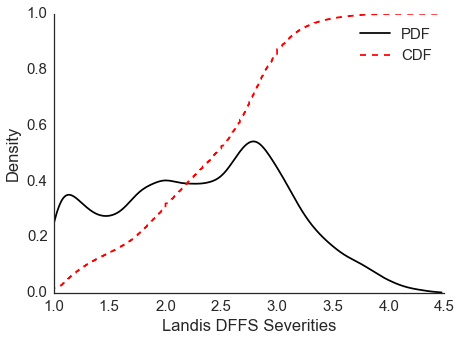

In [176]:
# We need to sort our PDF data by severity, our index
sortedDF = sevData.sort_values('severities').dropna()


f, ax = plt.subplots(1,1, figsize =(7,5))

# Here, we need to normalize the PDF data such that once we integrate over the 
# sorted index (severity), we will sum to unity. Thats what the sortedDF.density.sum() call is for.
ax.plot(sortedDF.severities, sortedDF.density, '-k', label='PDF')
ax.plot(sortedDF.severities, sortedDF.density.cumsum()/sortedDF.density.sum(), '--r', label='CDF')

# For the sake of future me, lets make a column withour CDF data
sortedDF['CDF'] = sortedDF.density.cumsum()/sortedDF.density.sum()

ax.legend(loc='best')
ax.set_xlabel('Landis DFFS Severities')
ax.set_ylabel('Density')
sns.despine()

### Alright, now we can get at our driving question here:
##### What % of the landscape are we talking about when we look at mean severity in each of our bins?
Are those severity bins reasonable? Our dope ass pie chart suggests no.. lets calculate those percentages using the CDF to pass the laugh test, then start asking some more of our data set. I'm beginning to think that MEAN Severity in this case might be bullshit, and that we should pull in all of the continuous fire data, make a giant stack, and produce a histogram of per pixel actual fire severities. Lets see if we can avoid doing that, for the sake of computation time.

In [207]:
print sortedDF.severities[sortedDF.CDF >= 0.35].iloc[0]
print sortedDF.severities[sortedDF.CDF >= 0.9993].iloc[0]
print sortedDF.severities[sortedDF.CDF >= 0.9995].iloc[0]

2.09090909091
3.96428571429
4.0


#### So, these bins are pretty skewed, which is alright..
But maybe we should try and get a little more quantititative. If we ask 'What percentile of our distribution are severities >= 3.5?' we can see its actually a tiny chunk... were in the 98th percentile, and only dealing with 5.5% of the landscape, or 2515 acres.

In [224]:
print sortedDF[sortedDF.severities > 3.5].count() 
print sortedDF[sortedDF.severities > 3.5].iloc[0]
print sortedDF[sortedDF.severities > 3.5].count()/45256 * 100

density       2515
severities    2515
CDF           2515
dtype: int64
density       0.163120
severities    3.511111
CDF           0.984677
Name: 43451, dtype: float64
density       5.557274
severities    5.557274
CDF           5.557274
dtype: float64


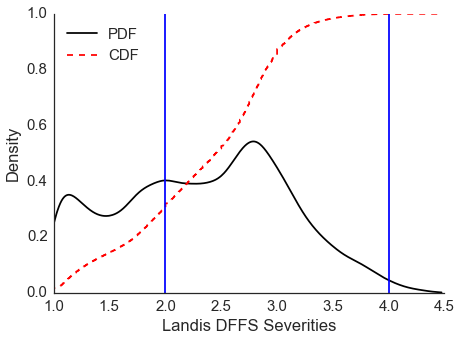

In [292]:
f, ax = plt.subplots(1,1, figsize =(7,5))

# Here, we need to normalize the PDF data such that once we integrate over the 
# sorted index (severity), we will sum to unity. Thats what the sortedDF.density.sum() call is for.
ax.plot(sortedDF.severities, sortedDF.density, '-k', label='PDF')
ax.plot(sortedDF.severities, sortedDF.density.cumsum()/sortedDF.density.sum(), '--r', label='CDF')

ax.axvline(2)
ax.axvline(4)

#sortedDF[sortedDF.severities > 3.5]

ax.legend(loc='best')
ax.set_xlabel('Landis DFFS Severities')
ax.set_ylabel('Density')
sns.despine()

plt.savefig('MeanSeverityPDF_CDF.tif')

### Mean severity is a tricky beast
And I don't think its going to cut it. I wanted to avoid building burn probabilities for each grid cell in the simulation using the 5,000 rasters involved, but a recent chat with Matt arrived at the same conclusion. So, the plan is to build a probability of high severity (4-5) raster, by calculating the fraction of burned at high severity / number of fires per pixel.

Step 1, generate the raster stack. Leverage the previously written function here to do so, slightly modified to produce additional outputs.

In [294]:
def severityPGen(rasterList):   
    # Stack the rasters
    rasterStack = np.dstack(rasterList)
    
    # Adjust fire severity by -2 (scale it to 1-5)
    rasterAdj = rasterStack - 2
    
    # Make all resulting negatives = NaN
    rasterAdj[rasterAdj < 0] = np.nan
    
    # Calculate the mean and variance of the stack
    # along axis 2 (the z axis)
    meanSev = np.nanmean(rasterAdj, axis = 2)
    varSev = np.nanvar(rasterAdj, axis = 2)

    # Create a raster layer to count the number of fires.
    fireMask = rasterStack - 2
    fireMask[fireMask <= 0] = np.nan

    # Here, we take each fire raster and assign
    # all fires with severity >= 1 a value of 1.
    fireMask[fireMask > 0] = 1

    # Tally them up, reset no data value
    totalFires = np.nansum(fireMask, axis = 2)
    totalFires[totalFires == 0] = np.nan

    # Now only count fires with severity >= 4 (High Severity)
    HSMask = rasterStack - 5
    HSMask[HSMask <= 0] = np.nan
    HSMask[HSMask > 0] = 1
    totalHSFires = np.nansum(HSMask, axis = 2)
    totalHSFires[totalHSFires ==0] = np.nan

    # Calculate the probability of high severity fire as the count of HS / count of Total Fires
    pHS_Fires = totalHSFires / totalFires
    
    return meanSev, varSev, totalFires, totalHSFires, pHS_Fires

In [295]:
# Call the new function
meansev, varsev, totalFires, totalHSFires, pHS_Fire = severityPGen(sevrasters)

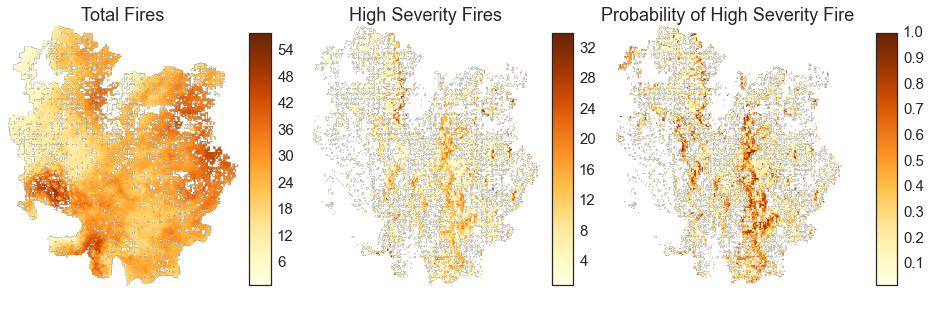

In [296]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize =(15,5))
plt.subplots_adjust(wspace = 0.3, hspace = 0.1)
firesTotal = ax1.imshow(totalFires, cmap = 'YlOrBr')
HSfiresTotal = ax2.imshow(totalHSFires, cmap = 'YlOrBr')
HSFire_Probability = ax3.imshow(pHS_Fire, cmap = 'YlOrBr')


# Remove the axes
sns.despine()
for ax in f.axes:
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

# Add the color bars
cbar_ax1 = f.add_axes([0.35, 0.18, 0.02, 0.7])
f.colorbar(firesTotal, cax=cbar_ax1)

cbar_ax2 = f.add_axes([0.63, 0.18, 0.02, 0.7])
f.colorbar(HSfiresTotal, cax=cbar_ax2)

cbar_ax3 = f.add_axes([0.93, 0.18, 0.02, 0.7])
f.colorbar(HSFire_Probability, cax=cbar_ax3)

ax1.set_title('Total Fires')
ax2.set_title('High Severity Fires')
ax3.set_title('Probability of High Severity Fire')

sns.set_style('white')
sns.set_context('notebook',font_scale=1.5)
plt.savefig('FireCountsAndProbability.tif')